# **Importar paquetes y datos**📰

In [ ]:
#Hadji Dejan Loaiciga Herrera
from __future__ import absolute_import,division,print_function,unicode_literals
import tensorflow.compat.v2 as tf2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math



dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') #Datos de entrenamiento
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') #Datos de prueba




### **Visualizar datos**

In [ ]:
dfeval.head()


,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y
3,1,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,1,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [ ]:
dftrain.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


Filtro
Pasa los que tenian el estado sobrevivientes de los datos de entrenamiento a y_train

In [ ]:
y_train=dftrain.pop('survived')
y_eval=dfeval.pop('survived')
#Para ejecutar este codigo sin problemas hay que volver a cargar los datos
#ejecutar de nuevo el bloque Importar paquetes y datos

In [ ]:
print(y_train)

0      0
1      0
2      1
3      1
4      1
      ..
259    1
260    0
261    0
262    0
263    1
Name: survived, Length: 264, dtype: int64


Localiza un elemento pasajero superviviente por eso se realiza la comparacion de los datos de entrenamiento con los datos filtrados en la variable y_train.loc[3]

Siendo Name: 8  la posicion del objeto y  dtype: object 0  el estado object 1 para sobrevivio y  object 0 para no sobrevivio

In [ ]:
print( dftrain.loc[8],y_train.loc[8])

sex                        female
age                           4.0
n_siblings_spouses              1
parch                           1
fare                         16.7
class                       Third
deck                            G
embark_town           Southampton
alone                           n
Name: 8, dtype: object 1


In [ ]:
dftrain.describe()#estadisticas

,survived,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000,627.000000
mean,0.387560,29.631308,0.545455,0.379585,34.385399
std,0.487582,12.511818,1.151090,0.792999,54.597730
min,0.000000,0.750000,0.000000,0.000000,0.000000
25%,0.000000,23.000000,0.000000,0.000000,7.895800
50%,0.000000,28.000000,0.000000,0.000000,15.045800
75%,1.000000,35.000000,1.000000,0.000000,31.387500
max,1.000000,80.000000,8.000000,5.000000,512.329200


In [ ]:
dftrain.shape

(627, 10)

## **Grafico** **Histograma**📊

<Axes: >

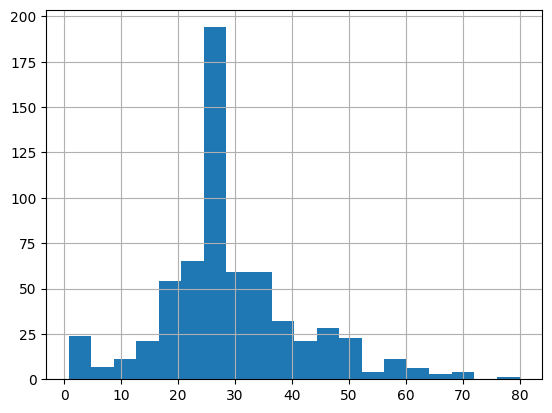

In [ ]:
dftrain.age.hist(bins=20)

<Axes: ylabel='sex'>

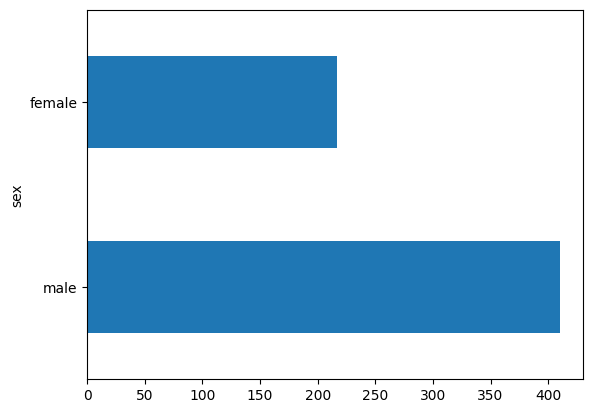

In [ ]:
dftrain.sex.value_counts().plot(kind='barh')

<Axes: ylabel='class'>

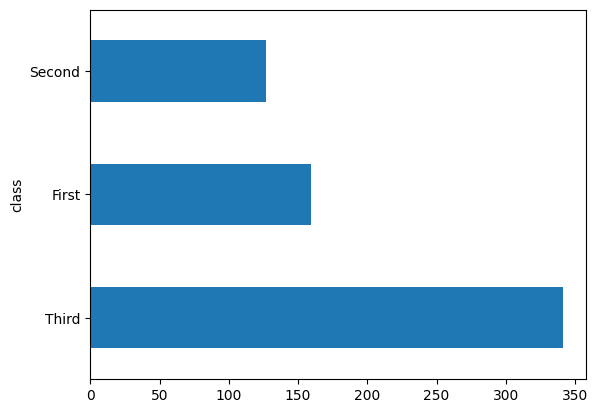

In [ ]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% susrvive')

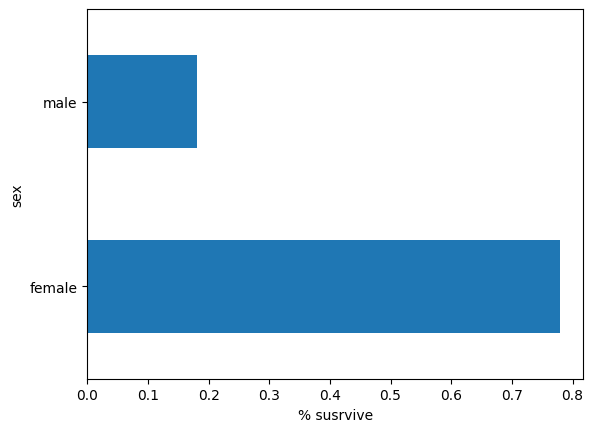

In [ ]:
pd.concat([dftrain,y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% susrvive')

# **Testeo de datos** 📝

In [ ]:
CATEGORICAL_COLUMNS = ['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']

NUMERIC_COLUMNS=['age','fare']

feature_columns=[]

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary))

for feature_name in NUMERIC_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype=tf.float32))

print(feature_columns)
##imprime el nombre de las columnas y un listado de los diferentes valores esperados: Numerico,texto,etc

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

# **Entrenamiento🏋️‍♂️**

Si este codigo da problemas. Ejecutar todos los codigos de arriba

**Preparacion**

In [ ]:
def make_input_fn(data_df,label_df,num_epoch=10, shuffle=True, batch_size=32):
  def input_function():
    ds=tf.data.Dataset.from_tensor_slices((dict(data_df),label_df))
    if shuffle:
      ds=ds.shuffle(1000)
    ds=ds.batch(batch_size).repeat(num_epoch)
    return ds
  return input_function

train_input_fn=make_input_fn(dftrain,y_train)
eval_input_fn=make_input_fn(dfeval,y_eval,num_epoch=1,shuffle=False)


#Respetar la identacion o espacio de sangría

**Entreno**

In [ ]:

linear_est =tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn) #Entrenando
result=linear_est.evaluate(eval_input_fn) #Obtinene las estadisticas del modelo y prueba

clear_output()
print(result['accuracy'])
print(result)


0.7462121
{'accuracy': 0.7462121, 'accuracy_baseline': 0.625, 'auc': 0.83468014, 'auc_precision_recall': 0.78724927, 'average_loss': 0.47620133, 'label/mean': 0.375, 'loss': 0.4686433, 'precision': 0.66, 'prediction/mean': 0.39357218, 'recall': 0.6666667, 'global_step': 200}


In [ ]:
result=list(linear_est.predict(eval_input_fn))
print(dfeval.loc[2])
print(y_eval.loc[2])
print("Probabilidad de Supervivencia: "+str(result[2]['probabilities'][1])+" %")

sex                        female
age                          58.0
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           Southampton
alone                           y
Name: 2, dtype: object
1
Probabilidad de Supervivencia: 0.74792355 %
